In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [5]:
# % matplotlib inline 

UsageError: Line magic function `%` not found.


In [98]:
J2_2019 = pd.read_excel('sale_movements/sales_movements_J2.xlsx', sheet_name = '2019')
J2_2018 = pd.read_excel('sale_movements/sales_movements_J2.xlsx', sheet_name = '2018')

In [100]:
J2_2018.shape

(55043, 21)

In [102]:
J2_2019.shape

(21812, 21)

In [101]:
J2_sales.shape

(24593, 21)

In [71]:
J2_sales = pd.read_excel('sale_movements/sales_movements_J2.xlsx')

In [77]:
a = pd.read_excel('sale_movements/sales_movements_J2.xlsx')

In [ ]:
# C2_sales = pd.read_excel('sale_movements/sales_movements_C2.xlsx')

In [8]:
lost_sales = pd.read_excel("Lost Sales.xlsx", sheet_name = "LostSalesAll")

In [14]:
lost_sales.Warehouse.unique()

array(['B3', 'C2', 'D1', 'E1', 'EL', 'J1', 'L1', 'N1', 'P2', 'G1', 'J2',
       'LI', 'J3', nan, 'L2', '+', '01', 'CLK89', 'J', '94193', '217-1',
       'MZ040', '5', 'BJSH4', 'C1', '213-1', 'JC', 'CVSK1', ' E1',
       'FD022', 'RDCAP', 'SHG90', 'B1', 'JJ1', '0P2', ' C2', '1', '316-1',
       '.', 'GFGL1', 'P21', 'AC2', '216-1', 'CVSMZ', 'BC2', '3', '03',
       'CVC2', 'P', '`P2', 'FD036', 'RFVW0', 'DG360', '212-1', '1C2'],
      dtype=object)

In [9]:
J2_sales.head()

,StockCode,Warehouse,TrnYear,TrnMonth,EntryDate,TrnTime,MovementType,TrnQty,TrnValue,UnitCost,SalesOrder,Invoice,DocType,Customer,CostValue,Branch,Salesperson,SalesBin,CustomerPoNumber,ProductClass,DateInfoPulled
0,FD0053BN01PL,A1,2017,7,2016-09-26,10062361,S,-1,-2403.0,1062.75246,OA18002972,IA18002935,C,AROO010,-1062.75,A1,A37,6A04A,RMA:RA10002979,BNP,2019-09-25
1,WS990389-GB-ZZ,A1,2017,7,2016-09-26,10100164,S,1,660.0,562.62264,OA10020832,IA10015627,I,ACAS161,562.62,A1,A06,GB2701,,WSZ,2019-09-25
2,WS070297-GY-RPE-ZZ,A1,2017,7,2016-09-26,10124912,S,1,1008.0,900.26314,OA10020833,IA10015628,I,ACAS162,900.26,A1,A22,GB2402,ASHLEY,WSZ,2019-09-25
3,TP484403535ROLL,A1,2017,7,2016-09-26,10124942,S,4,64.0,14.13510,OA10020833,IA10015628,I,ACAS162,56.54,A1,A22,CAGE,ASHLEY,TP,2019-09-25
4,WSR390312,A1,2017,7,2016-09-26,10165867,S,1,825.0,479.89789,OA10020834,IA10015629,I,ACAS162,479.90,A1,A30,20C04B,,WSR,2019-09-25


In [ ]:
sales.loc[:, "count"] = sales.groupby('StockCode')['StockCode'].transform('count')

In [78]:
b = a[a.columns[[0,4,7]]]

In [80]:
def loss_function(sales, loss_sales, wh, windowSize):
    lost_sales_dict = {}
    """"
    t a dictionary mapping a sales code to an array where index 0 is the 
    number of times a lost sale ocurred and index 1 is the total of lost quantity
   
    """
    sales = sales[sales.columns[[0,4,7]]]
    sales.loc[:, 'TrnQty'] = sales['TrnQty'].abs()
    for index,row in loss_sales.iterrows():
        code = row["StockCode"]
        warehouse = row["Warehouse"]
        if warehouse == wh:
            if code in lost_sales_dict.keys(): 
                lost_sales_dict[code][0] += 1
                lost_sales_dict[code][1] += row["QuantityLost"] 
            else:
                lost_sales_dict[code] = []
                lost_sales_dict[code].append(1)
                lost_sales_dict[code].append(row["QuantityLost"])
                
    TrnQty_withLoss = []
    sales = sales.groupby(["StockCode","EntryDate"])['TrnQty'].sum().reset_index()
    for index, row in sales.iterrows():
        code = row["StockCode"]
        TrnQty = row['TrnQty']
        if code in lost_sales_dict.keys(): 
            lostSalesAvg = lost_sales_dict[code][1] / lost_sales_dict[code][0]
            TrnQty_withLoss.append(TrnQty + lostSalesAvg)
        else:
            TrnQty_withLoss.append(TrnQty)
            
    sales.loc[:, "TrnQty_withLoss"] = TrnQty_withLoss
    
    sales.loc[:, "count"] = sales.groupby('StockCode')['StockCode'].transform('count')
    
    
    """Creating sliding window filtering out any stockcodes less than 10"""
    sales.loc[:, "EntryDate"] = pd.to_datetime(sales['EntryDate'])
    sales = sales[sales['count'] > windowSize]
    
    for index, row in sales.iterrows():
        code = row["StockCode"]
        sales.loc[sales.StockCode == code, 'mean'] = sales[
            sales.StockCode == code].TrnQty_withLoss.rolling(windowSize, min_periods = 1).mean()
        sales.loc[sales.StockCode == code, 'std'] = sales[
            sales.StockCode == code].TrnQty_withLoss.rolling(windowSize, min_periods = 1).std()

    return sales

In [103]:
dwrw2018 = loss_function(J2_2018, lost_sales, "J2", 10)

/Users/dongxujia/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [81]:
data_withLoss = loss_function(J2_sales, lost_sales, "J2", 10)

/Users/dongxujia/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [93]:
J2_sales[J2_sales["EntryDate"] == 'A']["TrnQty"]

Series([], Name: TrnQty, dtype: int64)

In [106]:
dwrw2018.loc[552]

StockCode                       409164
EntryDate          2017-06-01 00:00:00
TrnQty                              22
TrnQty_withLoss                71.3333
count                              249
mean                           172.133
std                            209.701
Name: 552, dtype: object

In [82]:
data_withLoss.head()

,StockCode,EntryDate,TrnQty,TrnQty_withLoss,count,mean,std
3,1419,2016-10-25,1,1.0,23,1.000000,NaN
4,1419,2016-10-27,6,6.0,23,3.500000,3.535534
5,1419,2016-11-07,6,6.0,23,4.333333,2.886751
6,1419,2016-11-09,1,1.0,23,3.500000,2.886751
7,1419,2016-11-10,1,1.0,23,3.000000,2.738613


In [113]:
def calculateError(dwrw, nextYear, sd, stockCode):
    error = 0
    count = 0
    nDf = dwrw[dwrw['StockCode'] == stockCode]
    nNy = nextYear[nextYear['StockCode'] == stockCode]
    nNy.loc[:, "EntryDate"] = pd.to_datetime(nNy['EntryDate'])
    nNy = nNy[nNy.columns[[0,4,7]]]
    nNy = nNy.groupby(["StockCode","EntryDate"])['TrnQty'].sum().reset_index()
    for index, row in nDf.iterrows():
        upperBound = row["mean"] + sd * row["std"]
        q = nNy[(nNy["EntryDate"].month == row["EntryDate"].month) and (nNy["EntryDate"].day == row["EntryDate"].day)]['TrnQty']
        if len(q) > 0:
            error += (q[0] - upperBound)**2
            count += 1
    return error/count
        

In [114]:
calculateError(dwrw2018, J2_2019, 2, '409164')

/Users/dongxujia/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


AttributeError: 'Series' object has no attribute 'month'

/Users/dongxujia/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


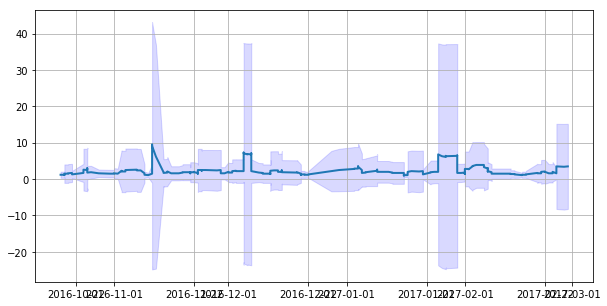

In [111]:
plt.figure(figsize = (10,5))
plt.grid(True)

plt.plot(mean, linewidth = 2);
plt.fill_between(std.index, (mean - 2 * std), (mean + 2 * std), color = 'b', alpha = .15);

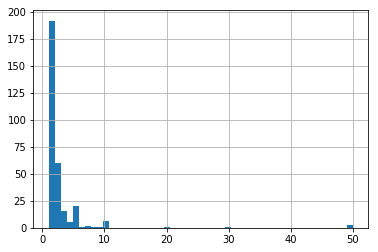

In [78]:
data_withLoss[data_withLoss.StockCode == 'RDTA0080'].TrnQty_withLoss.hist(bins = 50)